![A soccer pitch for an international match.](resources/soccer-pitch.jpg)

You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question you are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

# Steps
1. Import data
2. Clean and transform data
    - Filter data to constraints
        - FIFA World Cup matches
        - After 2002-01-01
3. Choose hypothesis test
    - Exploratory Data Analysis
    - Two independent groups
        - unpaired t-test or MWU test, depending on distribution
    - Women's mean goals are **greater** than men's mean goals
        - right tailed test
4. Perform hypothesis test
    - Return p_value
5. Interpret results
    - If p_value < alpha (0.1), reject the null hypothesis (The difference between mean goals scored between the two groups is not statistically significant) 

# Import Data

In [5]:
# Environment Setup & Data Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

results = pd.concat([
    pd.read_csv('data/women_results.csv').assign(gender='women'),
    pd.read_csv('data/men_results.csv').assign(gender='men')
], ignore_index=True)
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49237 entries, 0 to 49236
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  49237 non-null  int64 
 1   date        49237 non-null  object
 2   home_team   49237 non-null  object
 3   away_team   49237 non-null  object
 4   home_score  49237 non-null  int64 
 5   away_score  49237 non-null  int64 
 6   tournament  49237 non-null  object
 7   gender      49237 non-null  object
dtypes: int64(3), object(5)
memory usage: 3.0+ MB


# Clean & Transform Data

In [6]:
# Parse Dates
results['date'] = pd.to_datetime(results['date'])

# Create Combined Goals column
results['combined_goals'] = results['home_score'] + results['away_score']

# Find 'FIFA World Cup' syntax
print(results['tournament'][results['tournament'].str.contains('(?i)FIFA World Cup', na=False)].unique())

# Filter for 'FIFA World Cup' and after 2002-01-01 only
results = results[(results['tournament'] == 'FIFA World Cup') & (results['date'] > '2002-01-01')]

['FIFA World Cup' 'FIFA World Cup qualification']


# Choose Hypothesis Test - Exploratory Data Analysis

In [7]:
# Aggregate Summary
agg_summ = results.groupby('gender')['combined_goals'].agg(['sum', 'mean', 'max', 'count'])
print(agg_summ)

# Assign the summary stats to variables
men_goal_total, men_goal_mean, men_goal_max, men_sample_size = agg_summ.iloc[0]
women_goal_total, women_goal_mean, women_goal_max, women_sample_size = agg_summ.iloc[1]

        sum      mean  max  count
gender                           
men     965  2.513021    8    384
women   596  2.980000   13    200


In [8]:
from scipy.stats import shapiro

# Apply the Shapiro-Wilk test to check if each gender's goals scored are normally distributed
print("Women's Goals: ", shapiro(results[results['gender'] == 'women']['combined_goals']))
print("Men's Goals: ", shapiro(results[results['gender'] == 'men']['combined_goals']))

Women's Goals:  ShapiroResult(statistic=0.8491019332746058, pvalue=3.890829384462926e-13)
Men's Goals:  ShapiroResult(statistic=0.9266493059134338, pvalue=8.894989197030093e-13)


The p-values of each are incredibly small, so we reject the null hypothesis that the goals are not normally distributed. We can confirm this by visualizing them on a histogram.

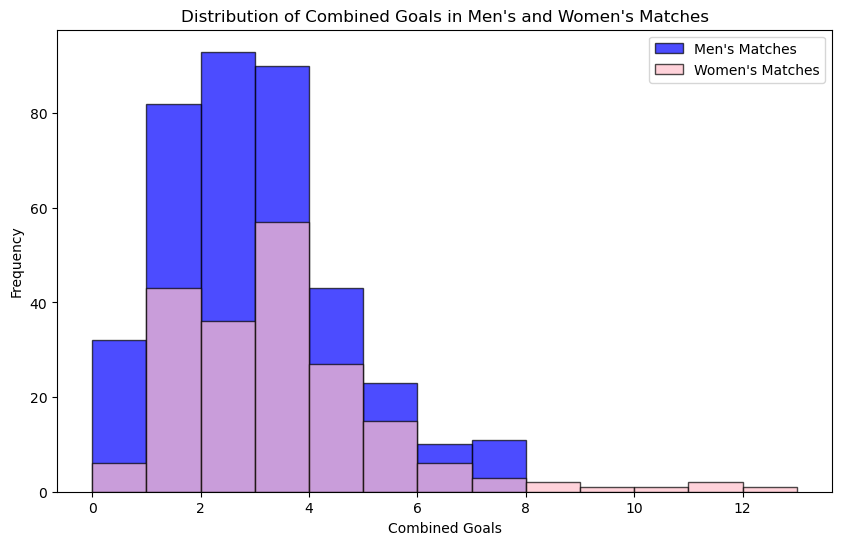

In [13]:
# Distribution of each gender's goals
women_goals = results[results['gender'] == 'women']['combined_goals']
men_goals = results[results['gender'] == 'men']['combined_goals']

# Plot the histograms
plt.figure(figsize=(10, 6))
plt.hist(men_goals,
         bins=int(men_goal_max), # Goals can only be whole numbers, so we can set the bins to the max of each
         alpha=0.7,
         label="Men's Matches",
         color='blue',
         edgecolor='black'
        )
plt.hist(women_goals,
         bins=int(women_goal_max),
         alpha=0.7,
         label="Women's Matches",
         color='pink',
         edgecolor='black'
        )

# Add titles and labels
plt.title("Distribution of Combined Goals in Men's and Women's Matches")
plt.xlabel('Combined Goals')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

# Perform Hypothesis Test
Because both groups have non-normal (right skewed) distributions, we will use the non-parametric Mann-Whitney U test

In [19]:
# Mann-Whitney U Test
import pingouin as pg

# Pivot to wide format
results_wide = results.pivot(columns='gender', values='combined_goals')

# Apply test
wmw_test = pg.mwu(x=results_wide['women'],
            y=results_wide['men'],
            alternative='greater')

print(wmw_test)

       U-val alternative     p-val       RBC      CLES
MWU  43273.0     greater  0.005107  0.126901  0.563451


# Interpret Results

In [20]:
# Store p-value
p_val = wmw_test.iloc[0].loc['p-val']
alpha = 0.1

# Reject or Fail to Reject the Null Hypothesis
if p_val <= alpha :
    result = 'reject'
else :
    result = 'fail to reject'
    
result_dict = {"p_val": p_val, "result": result}
print(result_dict)

{'p_val': 0.005106609825443641, 'result': 'reject'}


In conclusion, we fail to reject the null hypothesis, which states that "The mean number of goals scored in women's international soccer matches is the same as men's." This implies that there is, indeed, a statistically significant difference between the mean goals scored in FIFA World Cup women's matches (2.98) and FIFA World Cup men's matches (2.51).